## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv('../Cowboys&CigrettesCaseStudy/CowboyCigsData.csv')

### 1c. Explore the data


In [3]:
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


In [4]:
cigData.shape

(144, 3)

In [5]:
cigData.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

In [6]:
cigData.isnull().values.any()

False

## 2. Cleaning, transforming and visualizing

In [7]:
cigData.drop(['Unnamed: 0'], axis=1, inplace=True)

### 2b. Nomenclature

In [8]:
cigData = cigData.rename(columns={'Time':'Month'})

In [9]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

In [10]:
cigData['Month'] = pd.to_datetime(cigData['Month'])
cigData.set_index('Month', inplace = True)

Perfect! 

### 2d. Making a predictor variable `y`

In [11]:
y = cigData['#CigSales']

In [12]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

In [13]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

### 2f. Plotting `y`

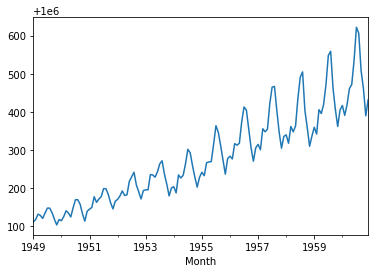

In [14]:
y.plot();

## 3. Modelling 
### 3a. Decomposition


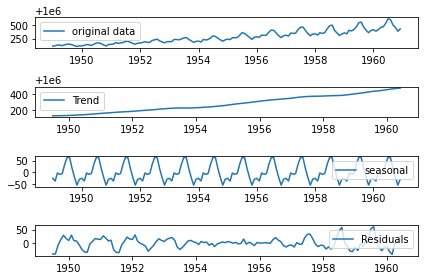

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
 
decomposition = seasonal_decompose(y)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.subplot(411)
plt.plot(y, label = 'original data')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'seasonal')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

### 3b. Testing for stationarity with KPSS


In [16]:
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings("ignore")
kpss(y)

(1.651312235417082,
 0.01,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### 3c. Making the data stationary 


In [17]:
y_log = np.log(y)

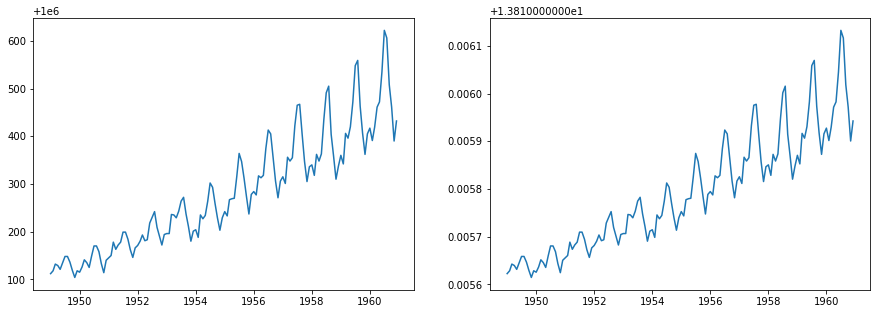

In [18]:
fig, axes = plt.subplots(1,2, figsize= (15,5), sharey=False)
axes[1].plot(y_log);
axes[0].plot(y);

In [19]:
kpss(y_log.diff().dropna())

(0.02389767420757057,
 0.1,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

MY p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model



In [20]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model


In [35]:
def evaluate_arima_model(data, arima_order):
    
    split=int(len(data) * 0.8) 
    
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    
    predictions = list()
    for i in range(len(test)):
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    
    error = mean_squared_error(test, predictions)
    
    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [36]:
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float('inf'), None   
    for p in p_values:        
        for d in d_values:            
            for q in q_values:                
                order = (p,d,q)
                try:                   
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA %s MSE=%.3f' % (best_cfg, best_score))
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]
evaluate_models(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.000
ARIMA(0, 0, 1) MSE=0.000
ARIMA(0, 0, 2) MSE=0.000
ARIMA(0, 1, 0) MSE=0.000
ARIMA(0, 1, 1) MSE=0.000
ARIMA(0, 1, 2) MSE=0.000
ARIMA(0, 2, 0) MSE=0.000
ARIMA(0, 2, 1) MSE=0.000
ARIMA(0, 2, 2) MSE=0.000
ARIMA(1, 0, 0) MSE=0.000
ARIMA(1, 0, 1) MSE=0.000
ARIMA(1, 0, 2) MSE=0.000
ARIMA(1, 1, 0) MSE=0.000
ARIMA(1, 1, 1) MSE=0.000
ARIMA(1, 1, 2) MSE=0.000
ARIMA(1, 2, 0) MSE=0.000
ARIMA(1, 2, 1) MSE=0.000
ARIMA(1, 2, 2) MSE=0.000
ARIMA(2, 0, 0) MSE=0.000
ARIMA(2, 0, 1) MSE=0.000
ARIMA(2, 0, 2) MSE=0.000
ARIMA(2, 1, 0) MSE=0.000
ARIMA(2, 1, 1) MSE=0.000
ARIMA(2, 1, 2) MSE=0.000
ARIMA(2, 2, 0) MSE=0.000
ARIMA(2, 2, 1) MSE=0.000
ARIMA(2, 2, 2) MSE=0.000
Best ARIMA (2, 1, 1) MSE=0.000


So the best p,d, q, parameters for the ARIMA model are 2, 1, 1 respectively. 

In [37]:
p=2
d=1
q=1
model = ARIMA(y_log, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

In [38]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              #CigSales   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1285.631
Date:                Wed, 27 Apr 2022   AIC                          -2563.263
Time:                        22:18:23   BIC                          -2551.411
Sample:                    01-01-1949   HQIC                         -2558.447
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0575    1.1e-19   9.59e+18      0.000       1.057       1.057
ar.L2         -0.4391   6.75e-19  -6.51e+17      0.000      -0.439      -0.439
ma.L1         -0.7080   3.02e-20  -2.35e+19      0.000      -0.708      -0.708
sigma2      8.444e-10   2.83e-10      2.983      0.003     2.9e-10     1.4e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.42   Prob(JB):                         0.73
Heteroskedasticity (H):               7.96   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.76e+36. Standard errors may be unstable.
"""

### 3e. Visualize the results 



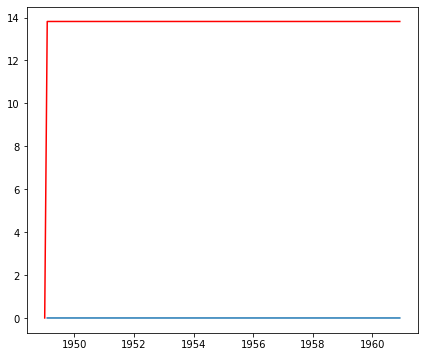

In [39]:
plt.figure(figsize=(7,6))
plt.plot(y_log.diff())
plt.plot(model_fit.predict(), color = 'red');

### 3f. Application: Forecasting



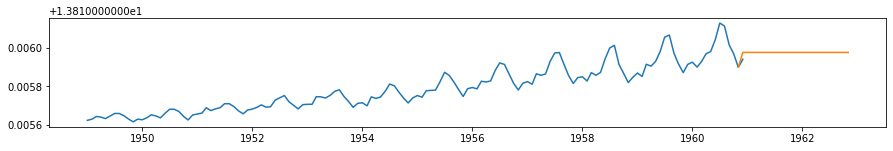

In [40]:
forecast_period = 24
date_range = pd.date_range(y_log.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()


future_months = pd.DataFrame(date_range, columns = ['Month'])

future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)
future_months['Prediction'] = forecast[0]


plt.figure(figsize=(15,2))
plt.plot(y_log)
plt.plot(y_log['Nov 1960'].append(future_months['Prediction']))
plt.show()

## 4. Evaluating and Concluding

The model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

